# Week 4 Assignment  
## K Means Clustering

In this assignment I will be segmenting the dataset using the k means algorythm

In [1]:
%matplotlib inline

# Import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

# Make results reproducible
np.random.seed(1234567890)

df = pd.read_csv('gapminder.csv')

variables = ['incomeperperson', 'polityscore', 'internetuserate', 'lifeexpectancy','urbanrate']

# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

# listwise deletion of missing values
subset = df[variables].dropna()

# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)

Size of study data
(153, 5)


## Data Management  

In [2]:
# Remove the first variable from the list since the target is derived from it
variables.pop(0)
variables.pop(0)

# Center and scale data
for variable in variables:
    subset[variable]=preprocessing.scale(subset[variable].astype('float64'))
    
features = subset[variables]
targets = subset[['incomeperperson', 'polityscore']]

### Split Data into Training and Test Sets  

In [3]:
training_data, test_data, training_target, test_target  = train_test_split(features, targets, test_size=.3)

## Determine the Number of Clusters

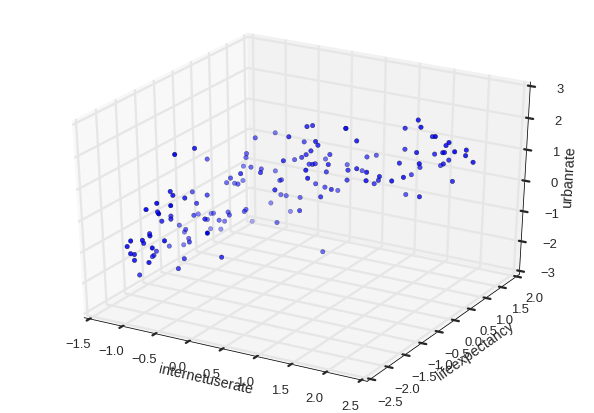

In [4]:
# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features.iloc[:,0], features.iloc[:,1], features.iloc[:,2])
ax.set_xlabel(features.columns.values[0])
ax.set_ylabel(features.columns.values[1])
ax.set_zlabel(features.columns.values[2])
plt.show()

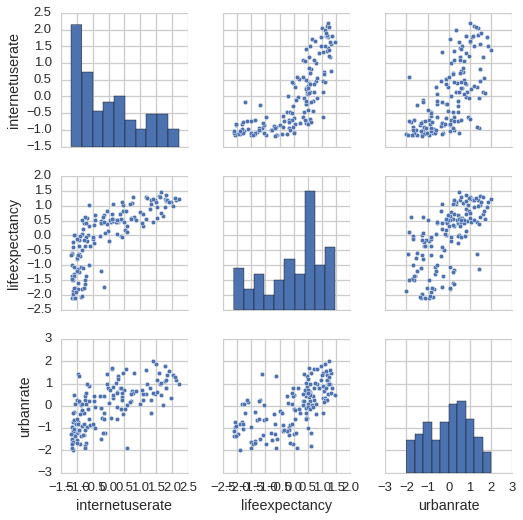

In [5]:
sns.pairplot(features);

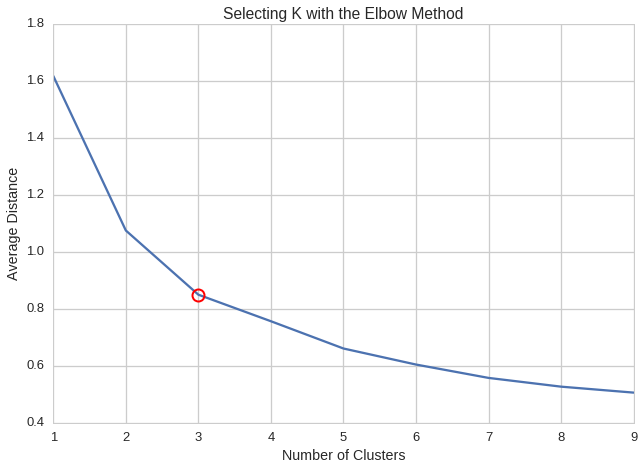

In [6]:
# Identify number of clusters using the elbow method
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(training_data)
    clusassign=model.predict(training_data)
    meandist.append(sum(np.min(cdist(training_data, model.cluster_centers_, 'euclidean'), axis=1)) / training_data.shape[0])

# Visualize the elbow
kIdx = 2 # K=3

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(clusters, meandist)
ax.plot(clusters[kIdx], meandist[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Selecting K with the Elbow Method')
plt.show()